# MNIST linear model  using lower-level TensorFlow operations

In this tutorial we will learn the basic building blocks of a Tensorflow model with dataset MNIST ("Hello World" for Machine Learning) on PowerAI.   
## Table of Contents
1. Download and preprocess datasets
2. Visualization pixels
3. Build Linear model 
    * Build a Softmax Regression Model
        * Variables, loss, optimizer
    * Train the Model
        * GPUs and CPUs control, Session(), initializer(), min_batch, epoch
4. Predefine model for MNIST by tensorflow home page
5. Evaluating Our Model



### Download dataset
#### Import libraries
Assume imports at top

In [1]:
import os #This module provides a portable way of using operating system dependent functionality.
import urllib #fetching data across the World Wide Web
import gzip   #compress and decompress files
import numpy as np  #NumPy is the fundamental package for scientific computing
import tensorflow as tf  #load tensorflow pakage

#### Path of Data sets


In [2]:
data_dir = "./MNIST_data/"   #dir to save dataset

TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
SOURCE_URL = "http://yann.lecun.com/exdb/mnist/"

In [3]:
# If the training and test sets aren't stored locally, download them.
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

if not os.path.exists(data_dir+TRAIN_IMAGES):
    raw = urllib.urlopen(SOURCE_URL+TRAIN_IMAGES).read()
    with open(data_dir+TRAIN_IMAGES, "w") as f:
        f.write(raw)

if not os.path.exists(data_dir+TRAIN_LABELS):
    raw = urllib.urlopen(SOURCE_URL+TRAIN_LABELS).read()
    with open(data_dir+TRAIN_LABELS, "w") as f:
        f.write(raw)

if not os.path.exists(data_dir+TEST_IMAGES):
    raw = urllib.urlopen(SOURCE_URL+TEST_IMAGES).read()
    with open(data_dir+TEST_IMAGES, "w") as f:
        f.write(raw)
        
if not os.path.exists(data_dir+TEST_LABELS):
    raw = urllib.urlopen(SOURCE_URL+TEST_LABELS).read()
    with open(data_dir+TEST_LABELS, "w") as f:
        f.write(raw)

In [4]:
# thses functions are from tensorflow/tensorflow/contrib/learn/python/learn/datasets/mnist.py
# to reformat dataset 

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]

def extract_images(f):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
    Args:
    f: A file object that can be passed into a gzip reader.
    Returns:
    data: A 4D uint8 numpy array [index, y, x, depth].
    Raises:
    ValueError: If the bytestream does not start with 2051.
    """
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                           (magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data

def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def extract_labels(f, one_hot=False, num_classes=10):
    """Extract the labels into a 1D uint8 numpy array [index].
    Args:
    f: A file object that can be passed into a gzip reader.
    one_hot: Does one hot encoding for the result.
    num_classes: Number of classes for the one hot encoding.
    Returns:
    labels: a 1D uint8 numpy array.
    Raises:
    ValueError: If the bystream doesn't start with 2049.
    """
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
              raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                           (magic, f.name))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        if one_hot:
              return dense_to_one_hot(labels, num_classes)
        return labels

#### load data and convert image format

In [5]:
one_hot = True
with open(data_dir+TRAIN_IMAGES, 'rb') as f:
    train_IMAGES = extract_images(f)
with open(data_dir+TRAIN_LABELS, 'rb') as f:
    train_LABELS = extract_labels(f, one_hot=one_hot)    
with open(data_dir+TEST_IMAGES, 'rb') as f:
    test_images = extract_images(f)    
with open(data_dir+TEST_LABELS, 'rb') as f:
    test_labels = extract_labels(f, one_hot=one_hot)    
    

('Extracting', './MNIST_data/train-images-idx3-ubyte.gz')
('Extracting', './MNIST_data/train-labels-idx1-ubyte.gz')
('Extracting', './MNIST_data/t10k-images-idx3-ubyte.gz')
('Extracting', './MNIST_data/t10k-labels-idx1-ubyte.gz')


#### Split taining dataset to train set and validation set
Using $sklearn.model\_selection.train\_test\_split$ is more common

In [6]:
NumberOfTrain=40000    # here we will chose 40000 images as train set and 20000 images as validation set
indices = np.random.permutation(train_IMAGES.shape[0])   # create a array from 0 to 60000 with random order
training_idx, validation_idx = indices[:NumberOfTrain],indices[NumberOfTrain:]
train_images, validation_images = train_IMAGES[training_idx,:],train_IMAGES[validation_idx,:]
train_labels, validation_labels = train_LABELS[training_idx,:],train_LABELS[validation_idx,:]

#### Print trainset, validation set and test set size

In [7]:
print("Number of train examples: %d" %train_images.shape[0])
print("Number of validation examples: %d" %validation_images.shape[0])
print("Number of test examples: %d" %test_images.shape[0])
print("Pixel siez: %d,%d" %(train_images.shape[1],train_images.shape[2]))
print("Label size: %d" %train_labels.shape[1])

Number of train examples: 40000
Number of validation examples: 20000
Number of test examples: 10000
Pixel siez: 28,28
Label size: 10


### Visualization pixels
Each image is 28 pixels by 28 pixels, and it can flatten to a vector 28 * 28 = 784
#### Visualization one pixel

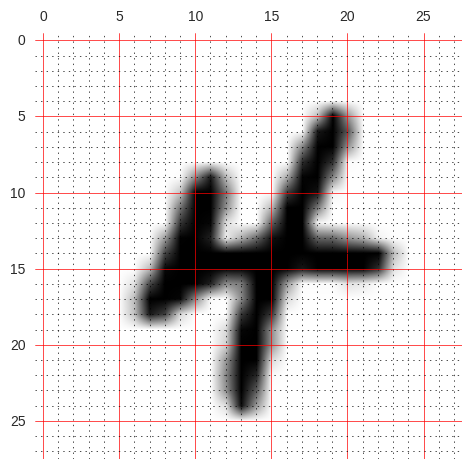

label: 4


In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

index_pixel = 5 # select a pixel to plot

label = train_labels[index_pixel]    
pixels = train_images[index_pixel]
pixels = pixels.reshape((28, 28))          # reshape vector to matrix 

plt.matshow(pixels, cmap='gray_r',interpolation=None)         # plot matrix
plt.minorticks_on()                        # Turn on the minor TICKS, which are required for the minor GRID
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor',  linestyle=':', linewidth='0.5', color='black')
plt.show() 
print("="*100)
print("label: %d" %np.where(label == 1))


#### Visualization more pixel

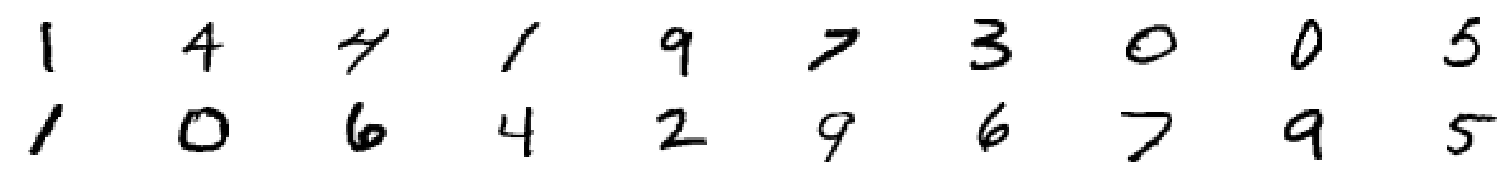

labels first line: [1], [4], [4], [1], [9], [7], [3], [0], [0], [5]
labels second line: [1], [0], [6], [4], [2], [9], [6], [7], [9], [5]


In [9]:
labels=[]
sns.set_style("dark")
fig, axes = plt.subplots(2, 10, figsize=(20, 2))

for i in xrange(2):
    for j in xrange(10):
        index_pixel = np.random.randint(0, 6000)
        axes[i][j].imshow(train_images[index_pixel].reshape(28, 28), cmap='gray_r', interpolation='nearest')
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        labels.extend(np.where(train_labels[index_pixel] == 1))
plt.show()          
print("="*100)
print("labels first line: " '%s' % ', '.join(map(str, labels[0:10])))
print("labels second line: " '%s' % ', '.join(map(str, labels[10:20])))

## Linear model 
TensorFlow relies on a highly efficient C++ backend to do its computation. The connection to this backend is called a session. The common usage for TensorFlow programs is to first create a graph and then launch it in a session.  

### Build a Softmax Regression Model
Here we will build a softmax regression model with a single linear layer.
#### Variables  

Creat symbolic variables with $tf.placeholder$, they are nodes for computation graph.  
$x$ is input node, where 784 is a pixel of 28 * 28, $None$ is number of pixel image to input   
$y\_$ is output target, each row is a one-hot 10-dimensional vector indicating which digit class (zero through nine) the corresponding MNIST image belongs to.  
$x,y\_$ are not specific values. They consist of a 2d tensor of floating point numbers  

A $Variable$ is a modifiable tensor that lives in TensorFlow's graph of interacting operations  
Notice that W has a shape of [784, 10] because we want to multiply the 784-dimensional image vectors by it to produce 10-dimensional vectors for the difference classes. b has a shape of [10] so we can add it to the output


In [10]:
x = tf.placeholder(tf.float32, [None, 784]) #Here None means that a dimension can be of any length.
y_ = tf.placeholder(tf.float32, [None, 10])

W = tf.Variable(tf.zeros([784, 10]))      
b = tf.Variable(tf.zeros([10]))

### Predicted Class and Loss Function
For regression model, we just multiply the vectorized input images $x$ by the weight $W$, add the bias $b$.  
we multiply $x$ by $W$ with the expression $tf.matmul(x, W)$. We then add b, and finally apply $tf.nn.softmax$.

In [11]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

Loss indicates how bad the model's prediction was on a single example; we try to minimize that while training across all the examples. Here, our loss function is the cross-entropy between the target and the softmax activation function applied to the model's prediction

In [12]:
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Note that $tf.nn.softmax\_cross\_entropy\_with\_logits$ internally applies the softmax on the model's unnormalized model prediction and sums across all classes, and $tf.reduce\_mean$ takes the average over these sums.

We define our model and loss function, now we can use TensorFlow to optimize the best modle. Here we are using the simplest  $tf.train.GradientDescentOptimizer()$, you can find more methode: https://www.tensorflow.org/api_guides/python/train#optimizers

In [13]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### Train the Model
####  Configurer devices
For TensorFlow, it will take all GPUs and memory by default. There are four GPUs in sharon03, so it's better to configure GPU and gpu_memory before we run the code.  
##### GPU control
There are two ways to define the number of GPU:  
* define CUDA enviroment: $export\ CUDA\_VISIBLE\_DEVICES=0,1$
* using $tf.device$ to select device(GPU or CPU) (https://www.tensorflow.org/tutorials/using_gpu)

##### Memory control  
* $allow\_growth$ option, which attempts to allocate only as much GPU memory based on runtime allocations: it starts out allocating very little memory, and as Sessions get run and more GPU memory is needed, we extend the GPU memory region needed by the TensorFlow process.
* $per\_process\_gpu\_memory\_fraction$ option, which determines the fraction of the overall amount of memory that each visible GPU should be allocated.  

See : https://www.tensorflow.org/tutorials/using_gpu  
Here we are using the first GPU and $allow\_growth$ mode

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print os.environ['CUDA_VISIBLE_DEVICES']
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

0


Here we instead use the convenient $InteractiveSession$ class, which makes TensorFlow more flexible about how you structure your code. It allows you to interleave operations which build a computation graph with ones that run the graph


In [15]:
sess = tf.InteractiveSession(config=config)

#### Create an operation to initialize the variables
$Variables$ must be initialized before used, here $tf.global\_variables\_initializer()$ will takes initial vales $zeros$ to all variables

In [16]:
tf.global_variables_initializer().run()

In [17]:
def batch(data,size):
    # convert dataset from 4D to 2D
    data_tmp=[]
    for i in range(size):
        data_tmp.append(np.asarray(data[i].reshape(data.shape[1]*data.shape[2])))
    return data_tmp  

#### Run the graph with min batch

In [18]:
batch_size= 200
for epoch in range(10):
    for min_batch in range(train_images.shape[0]/batch_size):
        batch_xs= batch(train_images[min_batch*batch_size:(min_batch+1)*batch_size],batch_size)
        batch_ys =train_labels[min_batch*batch_size:(min_batch+1)*batch_size]
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if epoch % 2 == 0:
        print(epoch, sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys}))

(0, 2.0761499)
(2, 1.9411501)
(4, 1.9261501)
(6, 1.9511501)
(8, 1.9411497)


#### Clear variables

In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Predefine model for MNIST by tensorflow home page
The code below is tutorial code, you can find them in TensorFlow homepage. It will do the same thing like we just did, but it is more efficient

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import os

# download and input dataset
mnist = input_data.read_data_sets("./MNIST_data/", one_hot=True)

# define the computational graph
x = tf.placeholder(tf.float32, [None, 784]) #Here None means that a dimension can be of any length.
y_ = tf.placeholder(tf.float32, [None, 10])

W = tf.Variable(tf.zeros([784, 10]))      
b = tf.Variable(tf.zeros([10]))
# comput prediction with softmax
y = tf.nn.softmax(tf.matmul(x, W) + b)
# define the loss and optimization method
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# run the graph,
## define GPU environment
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print os.environ['CUDA_VISIBLE_DEVICES']
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
# initializer all variables
tf.global_variables_initializer().run()
for epoch in range(10000):
    batch_xs, batch_ys = mnist.train.next_batch(200)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if epoch % 2000 == 0:
        print(epoch, sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys}))

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
0
(0, 2.2936635)
(2000, 1.5636083)
(4000, 1.5489941)
(6000, 1.531337)
(8000, 1.5591075)


## Evaluating Our Model
$tf.argmax$ is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. 

In [21]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Print the accuracy for test set

In [22]:
Accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print("Accuracy of test %f" %Accuracy )

Accuracy of test 0.926600
